In [2]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
#Our module is going to estimate those numbers
weight = 0.7
bias = 0.3

# Create data
X = torch.arange(0, 1, 0.02, device=device).unsqueeze(dim=1) #Device cuda?
Y = weight * X + bias

#60-80% Training set
#10-20% Validation set NOT OFTEN USED
#10-20% Testing set
train_split = int(0.8*(len(X)))
X_train, Y_train = X[:train_split], Y[:train_split]
X_test, Y_test = X[train_split:], Y[train_split:]


In [4]:
def plot_predictions(train_data=X_train, 
                     train_labels=Y_train, 
                     test_data=X_test, 
                     test_labels=Y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  # Plot training data in blue
  plt.scatter(train_data.cpu(), train_labels.cpu(), c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data.cpu(), test_labels.cpu(), c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data.cpu(), predictions.cpu(), c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 10})

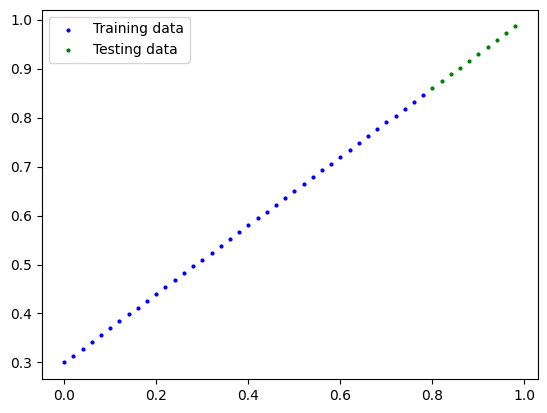

In [5]:
plot_predictions()
#We want to predict the green dots, and train on the blue ones

In [6]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1, device=device)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

OrderedDict([('linear_layer.weight', tensor([[-0.0446]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.5025], device='cuda:0'))])

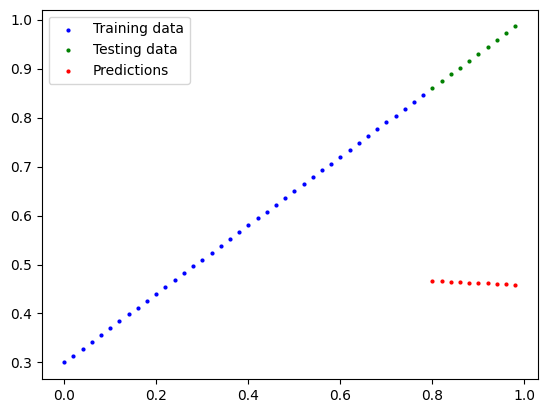

: 

In [12]:
torch.manual_seed(128)
model_0 = LinearRegressionModel()

#Making prediction
with torch.inference_mode():
    pred = model_0(X_test)

plot_predictions(predictions=pred)
model_0.state_dict()


In [8]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

#Optmizers visually https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c
# Create the optimizer
#optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)
#optimizer = torch.optim.AdamW(params=model_0.parameters(), lr=0.001 )


Epoch: 0 | MAE Train Loss: 0.1618870049715042 | MAE Test Loss: 0.4413033425807953 
Epoch: 10 | MAE Train Loss: 0.1311081498861313 | MAE Test Loss: 0.283040851354599 
Epoch: 20 | MAE Train Loss: 0.1147075816988945 | MAE Test Loss: 0.24937565624713898 
Epoch: 30 | MAE Train Loss: 0.09546785801649094 | MAE Test Loss: 0.23582999408245087 
Epoch: 40 | MAE Train Loss: 0.07607638090848923 | MAE Test Loss: 0.17805901169776917 
Epoch: 50 | MAE Train Loss: 0.056684911251068115 | MAE Test Loss: 0.1313696950674057 
Epoch: 60 | MAE Train Loss: 0.037002693861722946 | MAE Test Loss: 0.08378615230321884 
Epoch: 70 | MAE Train Loss: 0.01719331182539463 | MAE Test Loss: 0.03751371055841446 
Epoch: 80 | MAE Train Loss: 0.003691455814987421 | MAE Test Loss: 0.008761763572692871 
Epoch: 90 | MAE Train Loss: 0.005124840885400772 | MAE Test Loss: 0.01156227570027113 
Epoch: 100 | MAE Train Loss: 0.0028320306446403265 | MAE Test Loss: 0.009709673933684826 
Epoch: 110 | MAE Train Loss: 0.003970359917730093 | M

(OrderedDict([('linear_layer.weight', tensor([[0.6970]], device='cuda:0')),
              ('linear_layer.bias', tensor([0.2982], device='cuda:0'))]),
 0.7,
 0.3)

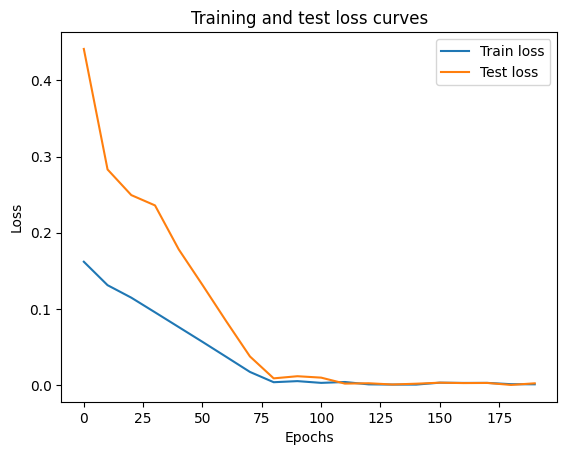

In [9]:
torch.manual_seed(128)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 200

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    model_0.train()
    y_pred = model_0(X_train)
    loss = loss_fn(y_pred, Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, Y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type


      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().cpu().numpy())
            test_loss_values.append(test_loss.detach().cpu().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

model_0.state_dict(), weight, bias

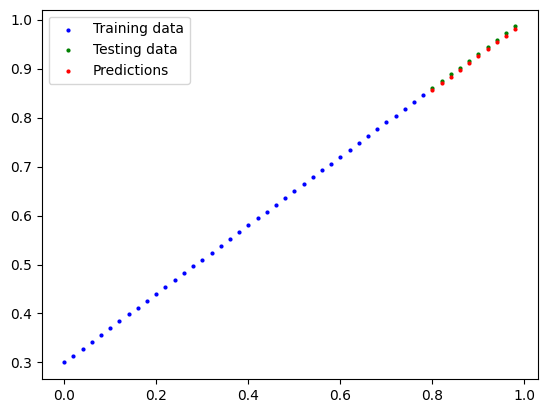

In [10]:
with torch.inference_mode():
    pred = model_0(X_test)

plot_predictions(predictions=pred)

In [11]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_0.state_dict()

Saving model to: models\01_pytorch_workflow_model_0.pth


OrderedDict([('linear_layer.weight', tensor([[0.6970]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2982], device='cuda:0'))])